In [1]:
import pandas as pd
# import the relevant Keras modules
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import html5lib
import lxml

Using TensorFlow backend.


Original code obtained from this notebook (https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb)

In [2]:
print("https://coinmarketcap.com/currencies/bitcoin/historical-data"+
                                   "?start=20130428&end="+time.strftime("%Y%m%d"))

https://coinmarketcap.com/currencies/bitcoin/historical-data?start=20130428&end=20180211


In [3]:
# Setting up bitcoin market info
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data"+
                                   "?start=20130428&end="+time.strftime("%Y%m%d"))[0]

bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
bitcoin_market_info.head()

Date     Open     High      Low    Close       Volume    Market Cap
0 2018-02-10  8720.08  9122.55  8295.47  8621.90   7780960000  146981000000
1 2018-02-09  8271.84  8736.98  7884.71  8736.98   6784820000  139412000000
2 2018-02-08  7637.86  8558.77  7637.86  8265.59   9346750000  128714000000
3 2018-02-07  7755.49  8509.11  7236.79  7621.30   9169280000  130683000000
4 2018-02-06  7051.75  7850.70  6048.26  7754.00  13999800000  118810000000

In [4]:
# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

Date    Open    High     Low   Close      Volume   Market Cap
0 2018-02-10  882.47  917.40  825.58  860.41  2930530000  86055600000
1 2018-02-09  818.48  884.00  788.83  883.87  2495820000  79799300000
2 2018-02-08  755.84  845.09  755.84  817.81  3708190000  73676900000
3 2018-02-07  790.43  851.20  723.43  757.07  3896180000  77032000000
4 2018-02-06  707.74  796.44  574.42  793.12  6518270000  68958700000

In [5]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

In [6]:
# Merging ETH and BTC dataframes on date
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

Date  bt_Open  bt_High   bt_Low  bt_Close    bt_Volume  bt_Market Cap  \
0 2018-02-10  8720.08  9122.55  8295.47   8621.90   7780960000   146981000000   
1 2018-02-09  8271.84  8736.98  7884.71   8736.98   6784820000   139412000000   
2 2018-02-08  7637.86  8558.77  7637.86   8265.59   9346750000   128714000000   
3 2018-02-07  7755.49  8509.11  7236.79   7621.30   9169280000   130683000000   
4 2018-02-06  7051.75  7850.70  6048.26   7754.00  13999800000   118810000000   

   eth_Open  eth_High  eth_Low  eth_Close  eth_Volume eth_Market Cap  \
0    882.47    917.40   825.58     860.41  2930530000    86055600000   
1    818.48    884.00   788.83     883.87  2495820000    79799300000   
2    755.84    845.09   755.84     817.81  3708190000    73676900000   
3    790.43    851.20   723.43     757.07  3896180000    77032000000   
4    707.74    796.44   574.42     793.12  6518270000    68958700000   

   bt_day_diff  eth_day_diff  
0    -0.011259     -0.024998  
1     0.056232      0.079892  
2     0.082187      0.081988  
3    -0.017303     -0.042205  
4     0.099585      0.120638

In [7]:
# Compuate volatility as (high - low) / open
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [8]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

Date  bt_Close  bt_Volume  bt_close_off_high  bt_volatility  \
771 2016-01-01    434.33   36278900          -0.560641       0.020292   
770 2016-01-02    433.44   30096600           0.250597       0.009641   
769 2016-01-03    430.01   39633800          -0.173865       0.020827   
768 2016-01-04    433.09   38477500          -0.474265       0.012649   
767 2016-01-05    431.96   34522600          -0.013333       0.010391   

     eth_Close  eth_Volume  eth_close_off_high  eth_volatility  
771   0.948024      206062           -0.418477        0.025040  
770   0.937124      255504            0.965898        0.034913  
769   0.971905      407632           -0.317885        0.060792  
768   0.954480      346245           -0.057657        0.047943  
767   0.950176      219833            0.697930        0.025236

In [9]:
# we don't need the date columns anymore
split_date = '2017-08-01'
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [10]:
window_len = 10
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close','Volume']]

In [11]:
# Dividing in chunks of size == window
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    # normalizing columns
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1

In [12]:
print(training_set['eth_Close'][window_len:].values.shape)
print(training_set['eth_Close'][:-window_len].values.shape)

(568,)
(568,)


In [13]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values)-1

In [14]:
LSTM_training_inputs[0]

bt_Close  bt_Volume  bt_close_off_high  bt_volatility  eth_Close  \
771  0.000000   0.000000          -0.560641       0.020292   0.000000   
770 -0.002049  -0.170410           0.250597       0.009641  -0.011498   
769 -0.009946   0.092475          -0.173865       0.020827   0.025190   
768 -0.002855   0.060603          -0.474265       0.012649   0.006810   
767 -0.005457  -0.048411          -0.013333       0.010391   0.002270   
766 -0.012019  -0.061645          -0.003623       0.012782   0.002991   
765  0.054613   1.413585          -0.951499       0.069045  -0.006349   
764  0.043515   0.570968           0.294196       0.032762   0.040890   
763  0.030576  -0.110282           0.814194       0.017094   0.040937   
762  0.031451  -0.007801          -0.919598       0.017758   0.054014   

     eth_Volume  eth_close_off_high  eth_volatility  
771    0.000000           -0.418477        0.025040  
770    0.239937            0.965898        0.034913  
769    0.978201           -0.317885        0.060792  
768    0.680295           -0.057657        0.047943  
767    0.066829            0.697930        0.025236  
766    0.498534           -0.214540        0.026263  
765    2.142074            0.681644        0.040587  
764    1.647747           -0.806717        0.055274  
763    0.098121           -0.411897        0.019021  
762    0.896944           -0.938235        0.025266

This table represents an example of our LSTM model input (we'll actually have hundreds of similar tables). We've normalised some columns so that their values are equal to 0 in the first time point, so we're aiming to predict changes in price relative to this timepoint. We're now ready to build the LSTM model. This is actually quite straightforward with Keras, you simply stack componenets on top of each other.

In [15]:
# Easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [16]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    shape1 = (inputs.shape[1], inputs.shape[2])
    print(shape1)
    model.add(LSTM(neurons, input_shape=shape1))
    
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [21]:
print(LSTM_training_inputs.shape)
print(training_set.shape)
print(LSTM_training_outputs.shape)

(568, 10, 8)
(578, 8)
(568,)


So, the build_model functions constructs an empty model unimaginatively called model (model = Sequential), to which an LSTM layer is added. That layer has been shaped to fit our inputs (n x m tables, where n and m represent the number of timepoints/rows and columns, respectively). The function also includes more generic neural network features, like dropout and activation functions. Now, we just need to specify the number of neurons to place in the LSTM layer (I've opted for 20 to keep runtime reasonable), as well as the data on which the model will be trained.

In [17]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=10, batch_size=1, verbose=2, shuffle=True)

(10, 8)
Epoch 1/10
 - 7s - loss: 0.1614
Epoch 2/10
 - 6s - loss: 0.1106
Epoch 3/10
 - 6s - loss: 0.0974
Epoch 4/10
 - 6s - loss: 0.0891
Epoch 5/10
 - 6s - loss: 0.0862
Epoch 6/10
 - 6s - loss: 0.0869
Epoch 7/10
 - 6s - loss: 0.0807
Epoch 8/10
 - 6s - loss: 0.0792
Epoch 9/10
 - 6s - loss: 0.0751
Epoch 10/10
 - 5s - loss: 0.0736


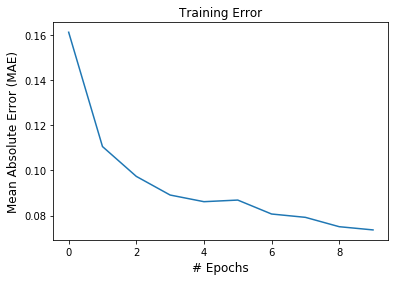

In [22]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()


We've just built an LSTM model to predict tomorrow's Ethereum closing price. Let's see how well it performs. We start by examining its performance on the training set (data before June 2017). That number below the code represents the model's mean absolute error (mae) on the training set after the 50th training iteration (or epoch). Instead of relative changes, we can view the model output as daily closing prices.

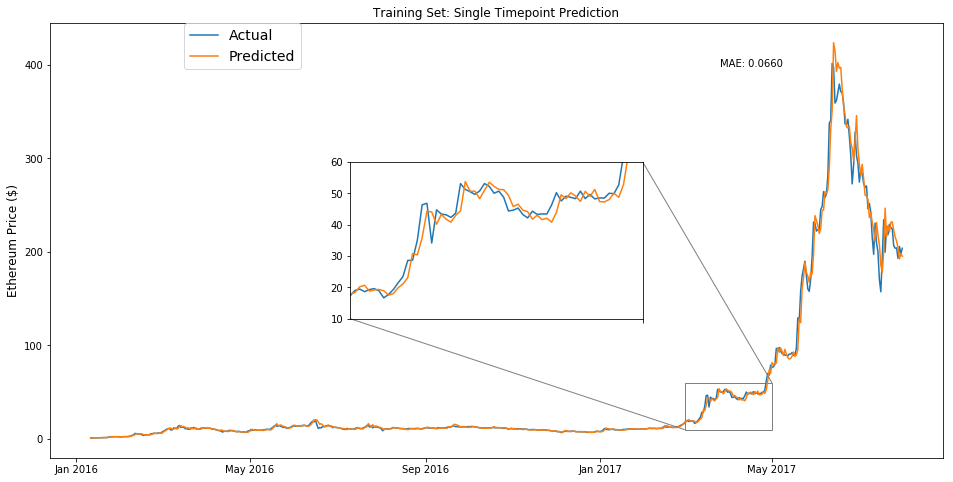

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1, figsize=(16,8))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['eth_Close'].values[window_len:])/(training_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 3.35, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([10,60])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

Not really impressive to fit the training data, let's plot the test data

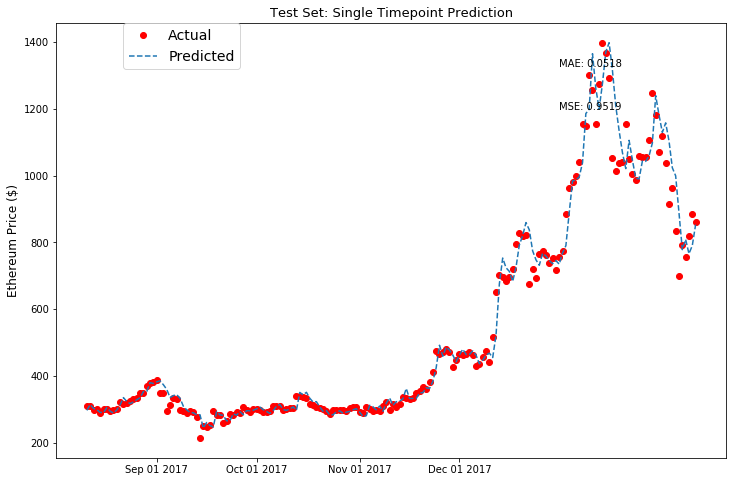

In [24]:
fig, ax1 = plt.subplots(1,1, figsize=(12,8))
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], 'ro',label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['eth_Close'].values[:-window_len])[0], 
         '--',
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['eth_Close'].values[window_len:])/(test_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.annotate('MSE: %.4f'%np.mean(((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['eth_Close'].values[window_len:])/(test_set['eth_Close'].values[:-window_len])).sum()), 
             xy=(0.75, 0.8),  xycoords='axes fraction',
            xytext=(0.75, 0.8), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

Continuing prediction for getting prices in the future

In [26]:
x = model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)
y = ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['eth_Close'].values[:-window_len])[0]

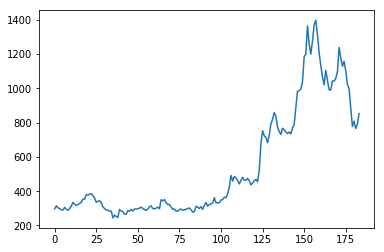

In [27]:
#training_set, test_set
plt.plot(y)
plt.show()

In [ ]:
x.max()

In [28]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['eth_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['eth_Close'][i:i+pred_range].values/
                                  training_set['eth_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=10, batch_size=1, verbose=2, shuffle=True)

(10, 8)
Epoch 1/10
 - 7s - loss: 0.2206
Epoch 2/10
 - 6s - loss: 0.1517
Epoch 3/10
 - 6s - loss: 0.1400
Epoch 4/10
 - 6s - loss: 0.1352
Epoch 5/10
 - 6s - loss: 0.1316
Epoch 6/10
 - 6s - loss: 0.1276
Epoch 7/10
 - 6s - loss: 0.1284
Epoch 8/10
 - 6s - loss: 0.1236
Epoch 9/10
 - 6s - loss: 0.1232
Epoch 10/10
 - 6s - loss: 0.1229


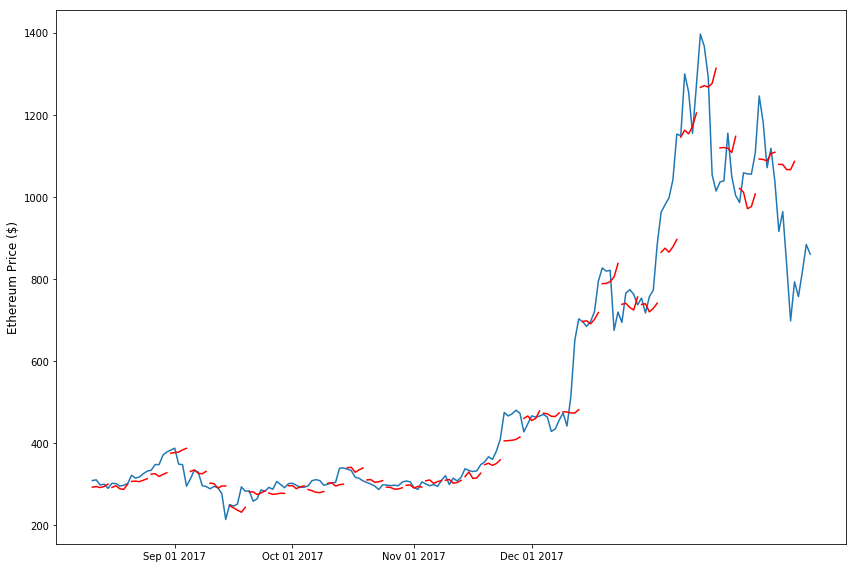

In [30]:
# little bit of reformatting the predictions to closing prices
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['eth_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, ax2 = plt.subplots(1,1, figsize=(12,8))
#ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
#ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
#         test_set['bt_Close'][window_len:], label='Actual')
ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')
for i, (eth_pred, bt_pred) in enumerate(zip(eth_pred_prices, bt_pred_prices)):
    ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
             eth_pred, color='red')
ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.set_xticklabels('')
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()

The predictions are visibly less impressive than their single point counterparts. Nevertheless, I'm pleased that the model returned somewhat nuanced behaviours (e.g. the second line on the eth graph); it didn't simply forecast prices to move uniformly in one direction. So there are some grounds for optimism.

Moving back to the single point predictions, our deep machine artificial neural model looks okay, but so did that boring random walk model. Like the random walk model, LSTM models can be sensitive to the choice of random seed (the model weights are initially randomly assigned). So, if we want to compare the two models, we'll run each one multiple (say, 25) times to get an estimate for the model error. The error will be calculated as the absolute difference between the actual and predicted closing prices changes in the test set.

In [36]:
eth_pred_prices[-1]

array([1079.25632703, 1078.80474919, 1066.293539  , 1066.38312565,
       1086.47322506])

# Conclusions

Nice model, trend is quite realistic. Hard to get reasonable data though, since a lot of data wrangling performed in the original notebook.